In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm_notebook as tqdm

import torch
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor, Normalize
from torch.utils.data import DataLoader, Subset
from copy import deepcopy
import json
from itertools import product

In [2]:
def imshow(image, label=None, figsize=(4,4), cmap='gray', **kwargs):
    plt.figure(figsize=figsize)
    if label is not None:
        print(label)
    plt.imshow(image, **kwargs, cmap=cmap)
    plt.show()

In [3]:
class Flatten:
    def __call__(self, img):
        return img.flatten()

# Data

In [4]:
N = 28
NUM_CLASSES = 10
SEED = 42

In [5]:
transforms = torchvision.transforms.Compose([
    ToTensor(),
    Normalize((0.1307,), (0.3081,)),
    Flatten(),
])

In [6]:
train_dataset = datasets.MNIST(root='../data', train=True, download=False, transform=transforms)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

In [7]:
test_dataset = datasets.MNIST(root='../data', train=False, download=False, transform=transforms)
# test_loader = DataLoader(Subset(test_dataset, np.arange(1_000)), batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [8]:
for img, label in test_loader:
    break

7


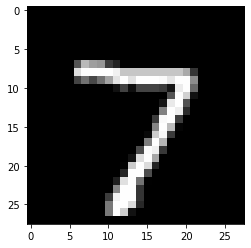

In [9]:
imshow(img[0].reshape(N, N), label=label[0].item())

# Activations

In [10]:
class Sigmoid():
    def forward(self, x):
        self.old_y = np.exp(x) / (1. + np.exp(x))
        return self.old_y

    def backward(self, grad):
        return self.old_y * (1. - self.old_y) * grad

# Costs

In [11]:
class MSE():
    def forward(self, x, y):
        self.old_x = x
        self.old_y = y
        return (1/2 * np.square(x-y)).mean()
    
    def backward(self):
        return (self.old_x - self.old_y).mean(axis=0)

# Layers

In [12]:
class Linear():
    def __init__(self, n_in, n_out):
        self.w = np.random.randn(n_in, n_out) * np.sqrt(2/n_in)
        self.b = np.zeros(n_out)

    def forward(self, x):
        self.old_x = x
        return np.dot(x,self.w) + self.b

    def backward(self,grad):
        self.grad_b = grad.mean(axis=0)
        self.grad_w = self.old_x.T @ grad
        return np.dot(grad, self.w.T)

In [80]:
class Dropout():
    def __init__(self, p):
        self.p = p
        self.training = True
        
    def forward(self, x):
        if self.training:
            self.mask = np.random.rand(*x.shape) < self.p
            return x * self.mask / (1 - self.p)
        return x

    def backward(self, grad):
        return grad * self.mask

# Optimizer

In [14]:
class SGD():
    def __init__(self, lr=0.01, l1=0, l2=0):
        self.lr = lr
        self.l1 = l1
        self.l2 = l2

    def init_params(self, model):
        self.model = model
        self.layers = [l  for l in model.layers if type(l) == Linear]

    def step(self):
        for layer in self.layers:
            layer.grad_w += self.l1 * np.sign(layer.w) + self.l2 * layer.w
            
            layer.w -= self.lr * layer.grad_w
            layer.b -= self.lr * layer.grad_b

In [102]:
class Adam():
    def __init__(self, lr=0.01, beta1=0.9, beta2=0.999, l1=0, l2=0):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = 1e-10
        self.l1 = l1
        self.l2 = l2
    
    def init_params(self, model):
        self.model = model
        self.layers = [l  for l in model.layers if type(l) == Linear]
                
        self.M_w = []
        self.M_b = []
        
        self.N_w = []
        self.N_b = []
        for l in self.layers:              
            self.M_w.append(np.zeros_like(l.w))
            self.M_b.append(np.zeros_like(l.b))
            
            self.N_w.append(np.zeros_like(l.w))
            self.N_b.append(np.zeros_like(l.b))
            
   
    def step(self):
        t = self.model.cur_epoch + 1
        for i, layer in enumerate(self.layers):
            layer.grad_w += self.l1 * layer.w + self.l2 * np.sign(layer.w)

            self.M_w[i] = self.beta1 * self.M_w[i] + (1 - self.beta1) * layer.grad_w
            self.M_b[i] = self.beta1 * self.M_b[i] + (1 - self.beta1) * layer.grad_b


            self.N_w[i] = self.beta2 * self.N_w[i] + (1 - self.beta2) * layer.grad_w ** 2
            self.N_b[i] = self.beta2 * self.N_b[i] + (1 - self.beta2) * layer.grad_b ** 2
            
            m_w_hat = self.M_w[i] / (1 - self.beta1 ** t)
            m_b_hat = self.M_b[i] / (1 - self.beta1 ** t)
            
            n_w_hat = self.N_w[i] / (1 - self.beta2 ** t)
            n_b_hat = self.N_b[i] / (1 - self.beta2 ** t)


            layer.w -= self.lr * m_w_hat / (np.sqrt(n_w_hat) + self.eps)
            layer.b -= self.lr * m_b_hat / (np.sqrt(n_b_hat) + self.eps)

# Model 

In [118]:
class Model():
    def __init__(self, layers, cost, optimizer):
        self.layers = layers
        self.cost = cost
        self.optimizer = optimizer
        self.optimizer.init_params(self)
        
    def one_hot(self, label):
        return np.eye(10)[label]
    
    def forward(self,x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def loss(self,x,y):
        return self.cost.forward(self.forward(x), y)

    def backward(self):
        grad = self.cost.backward()
        for i in range(len(self.layers)-1,-1,-1):
            grad = self.layers[i].backward(grad)
    
    def set_mode(self, mode):
        is_training = mode == 'train'
        for i in range(len(self.layers)):
            if hasattr(self.layers[i], 'is_training'):
                self.layers[i].is_training = is_training
    
    def train(self, train_loader, test_loader, epochs, num_samples=10_000, verbose=True):
        self.set_mode('train')
        samples = 0
        accs = []
        losses = []
        for epoch in tqdm(range(epochs)):
            self.cur_epoch = epoch
            for img, label in train_loader:
                bs = img.shape[0]
                y = self.one_hot(label)
                x = img.numpy()
                self.cur_x = x
                self.cur_y = y

                self.loss(x, y)
                self.backward()

                self.optimizer.step()
                
#                 samples += bs
#                 if samples > num_samples:
#                     break
            
            acc, loss = self.validate(test_loader)
            if verbose:
                print(f"epoch: {epoch}")
                print(f"loss: {loss:.5f} acc: {acc:.5f}")
            accs.append(acc)
            losses.append(loss)
        return accs, losses
    
    def validate(self, loader):
        self.set_mode('val')
        losses = []
        acc = 0
        counter = 0
        for img, label in loader:
            bs = img.shape[0]
            y = self.one_hot(label)
            x = img.numpy()
            
            preds = np.argmax(np.array(self.forward(x)), axis=1)
            labels = label.numpy()
            
            acc += sum(labels == preds)
            counter += bs
            
            losses.append(self.loss(x, y))
        return acc / counter, np.mean(losses)

In [16]:
EPOCHS = 20
LR = 0.002

# 1. train val error

In [17]:
TRAIN_SIZES = [0.2, 0.4, 0.6, 0.8]

In [18]:
TOTAL_TRAIN = len(train_dataset)

In [19]:
TOTAL_TRAIN

60000

In [20]:
TOTAL_TEST = len(test_dataset)

In [21]:
TOTAL_TEST / (TOTAL_TRAIN + TOTAL_TEST)

0.14285714285714285

In [22]:
EPOCHS = 100
LR = 0.001
BATCH_SIZE = 64

In [23]:
config = {
    'layers': [Linear(784, 100), Sigmoid(), Linear(100, 10), Sigmoid()], 
    'cost': MSE(),
    'optimizer': SGD(LR),
}

In [24]:
from collections import namedtuple
Exp = namedtuple('exp', 'name, acc, loss')

In [26]:
# experiments = []
# for ts in TRAIN_SIZES:
#     train_loader = DataLoader(
#         Subset(train_dataset, np.arange(TOTAL_TRAIN * ts, dtype=int)), batch_size=BATCH_SIZE, shuffle=True,
#     )
#     model = Model(**config)
#     acc, loss = model.train(train_loader, test_loader, epochs=EPOCHS, verbose=0)
#     name = f'{round(ts*100)}%'
#     experiments.append(Exp(name, acc, loss))

In [31]:
with open('train_exps.json', 'r') as f:
    loaded_exps = [Exp(**eval(d)) for d in json.load(f)]
experiments = loaded_exps

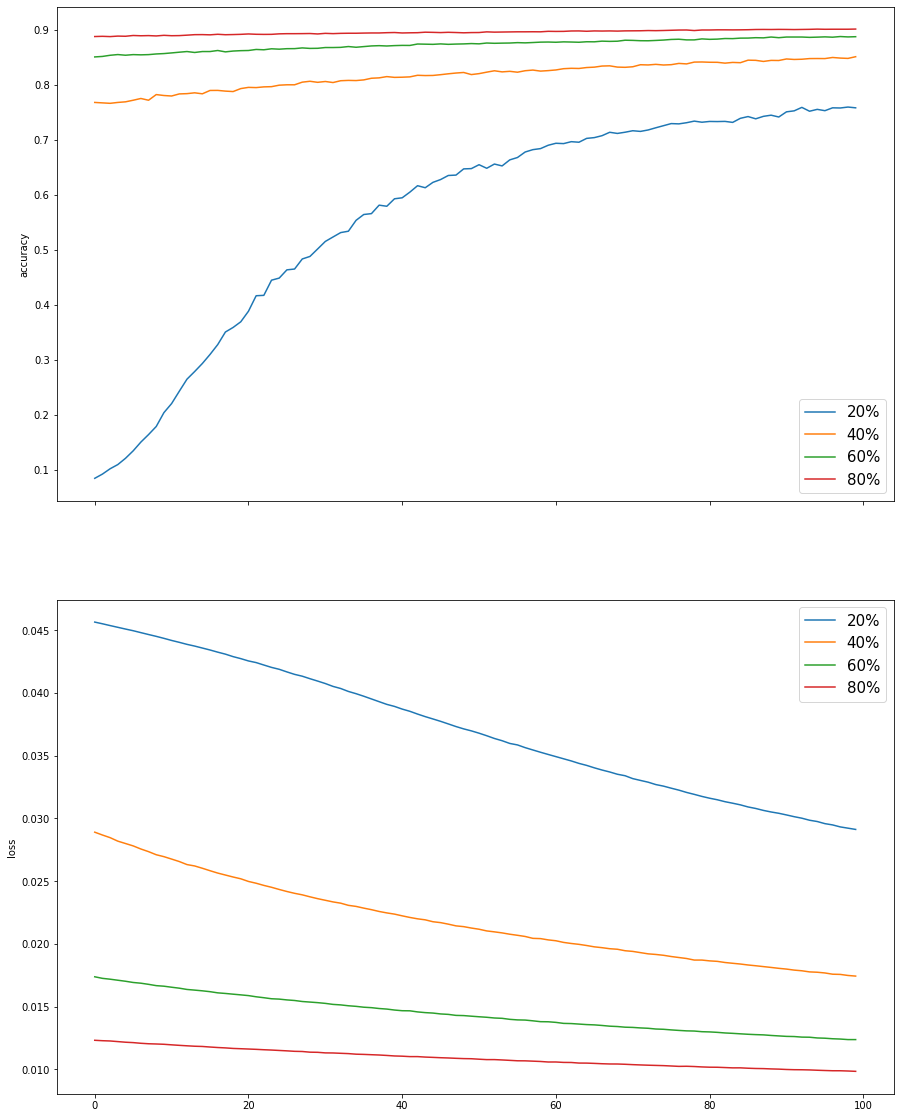

In [32]:
fig, axs = plt.subplots(nrows=2, figsize=(15, 20), sharex=False)
START_IDX = 0
names = [exp.name for exp in experiments[START_IDX:]]
for exp in experiments[START_IDX:]:
    axs[0].plot(exp.acc)
    axs[0].set(ylabel='accuracy')
    axs[1].plot(exp.loss)
    axs[1].set(ylabel='loss')
    
axs[0].legend(names, prop={'size': 15})
axs[1].legend(names, prop={'size': 15})

for ax in axs.flat:
    ax.label_outer()

### 1.1 save results

In [33]:
# to_save = [json.dumps(exp._asdict()) for exp in experiments]
# with open('train_exps.json', 'w') as f:
#     json.dump(to_save, f)

### 1.2 load results

In [34]:
# with open('train_exps.json', 'r') as f:
#     loaded_exps = [Exp(**eval(d)) for d in json.load(f)]

# 2. Model capacity

In [35]:
archs = {
    0: [Linear(784, 10), Sigmoid()],
    1: [Linear(784, 100), Sigmoid(), Linear(100, 10), Sigmoid()],
    2: [Linear(784, 100), Sigmoid(), Linear(100, 100), Sigmoid(), Linear(100, 10), Sigmoid()],
    3: [Linear(784, 100), Sigmoid(), Linear(100, 100), Sigmoid(), Linear(100, 100), Sigmoid(), Linear(100, 10), Sigmoid()],
}

In [36]:
EPOCHS = 20
BATCH_SIZE = 64
LR = 0.1

In [37]:
# capacity_exps = []
# train_loader = DataLoader(
#     Subset(train_dataset, np.arange(TOTAL_TRAIN * 0.6, dtype=int)), batch_size=BATCH_SIZE, shuffle=True,
# )
# for name, arch in archs.items():
#     model = Model(
#         layers=arch,
#         cost=MSE(),
#         optimizer=SGD(LR),
#     )
#     acc, loss = model.train(train_loader, test_loader, epochs=EPOCHS, verbose=0)
#     capacity_exps.append(Exp(name, acc, loss))

In [41]:
with open('capacity_exps.json', 'r') as f:
    loaded_exps = [Exp(**eval(d)) for d in json.load(f)]
capacity_exps = loaded_exps

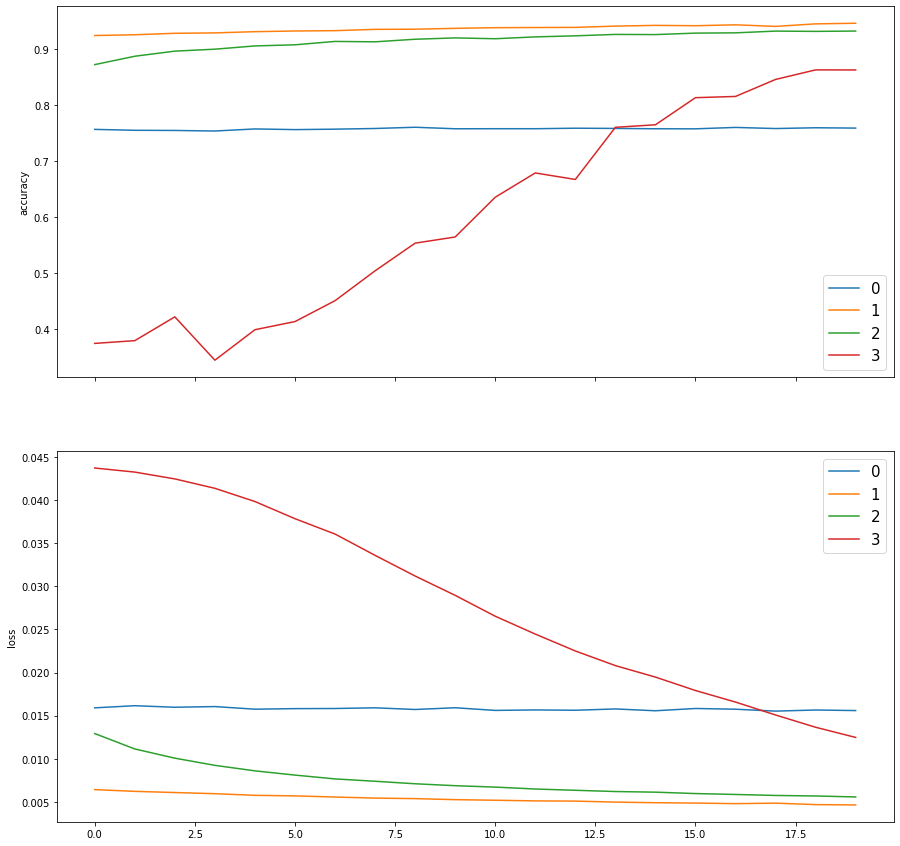

In [42]:
fig, axs = plt.subplots(nrows=2, figsize=(15, 15), sharex=True)
START_IDX = 0
names = [exp.name for exp in capacity_exps[START_IDX:]]
for exp in capacity_exps[START_IDX:]:
    axs[0].plot(exp.acc)
    axs[0].set(ylabel='accuracy')
    axs[1].plot(exp.loss)
    axs[1].set(ylabel='loss')
    
axs[0].legend(names, prop={'size': 15})
axs[1].legend(names, prop={'size': 15})

for ax in axs.flat:
    ax.label_outer()

In [81]:
# to_save = [json.dumps(exp._asdict()) for exp in capacity_exps]
# with open('capacity_exps.json', 'w') as f:
#     json.dump(to_save, f)

In [43]:
for e in capacity_exps:
    print(f'max accuracy for {e.name} layers: {max(e.acc)}')

max accuracy for 0 layers: 0.7603
max accuracy for 1 layers: 0.9456
max accuracy for 2 layers: 0.9317
max accuracy for 3 layers: 0.8625


best option: 1-2 hidden layer

# 3. Regularization

In [44]:
l2s = reversed([0.001, 0.0001, 0])
l1s = reversed([0.0001, 0])
EPOCHS = 50
BATCH_SIZE = 64
LR = 0.1

In [45]:
regularization_exrps = []
train_loader = DataLoader(
    Subset(train_dataset, np.arange(TOTAL_TRAIN, dtype=int)), batch_size=BATCH_SIZE, shuffle=True,
)
for l1, l2 in product(l1s, l2s):
    name = f'l1: {l1}, l2: {l2}'
    model = Model(
        layers=[Linear(784, 100), Sigmoid(), Linear(100, 100), Sigmoid(), Linear(100, 10), Sigmoid()],
        cost=MSE(),
        optimizer=SGD(LR, l1=l1, l2=l2),
    )
    acc, loss = model.train(train_loader, test_loader, epochs=EPOCHS, verbose=0)
    print(f'{name} acc: {max(acc)}')
    regularization_exrps.append(Exp(name, acc, loss))

In [48]:
with open('regulatization_exps.json', 'r') as f:
    loaded_exps = [Exp(**eval(d)) for d in json.load(f)]
regularization_exrps = loaded_exps

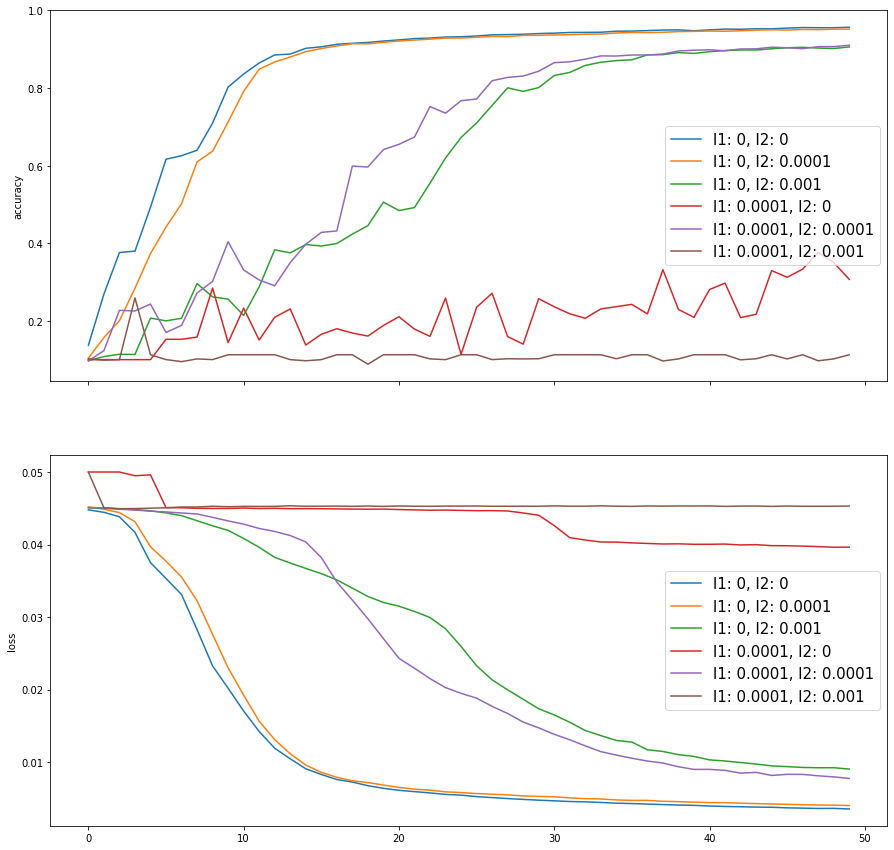

In [49]:
fig, axs = plt.subplots(nrows=2, figsize=(15, 15), sharex=True)
START_IDX = 0
names = [exp.name for exp in regularization_exrps[START_IDX:]]
for exp in regularization_exrps[START_IDX:]:
    axs[0].plot(exp.acc)
    axs[0].set(ylabel='accuracy')
    axs[1].plot(exp.loss)
    axs[1].set(ylabel='loss')
    
axs[0].legend(names, prop={'size': 15})
axs[1].legend(names, prop={'size': 15})

for ax in axs.flat:
    ax.label_outer()

In [115]:
# to_save = [json.dumps(exp._asdict()) for exp in regularization_exrps]
# with open('regulatization_exps.json', 'w') as f:
#     json.dump(to_save, f)

In [50]:
best = ('', 0)
for e in regularization_exrps:
    m = max(e.acc)
    n = e.name
    if m > best[1]:
        best = (n, m)
    print(f'acc for\t {n}: \t\t {m}')
print('-'*50)
print(f'overall best: {best}')

acc for	 l1: 0, l2: 0: 		 0.9568
acc for	 l1: 0, l2: 0.0001: 		 0.9518
acc for	 l1: 0, l2: 0.001: 		 0.9062
acc for	 l1: 0.0001, l2: 0: 		 0.3771
acc for	 l1: 0.0001, l2: 0.0001: 		 0.9105
acc for	 l1: 0.0001, l2: 0.001: 		 0.2599
--------------------------------------------------
overall best: ('l1: 0, l2: 0', 0.9568)


In [120]:
EPOCHS = 20
BATCH_SIZE = 64
LR = 0.01

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [151]:
class Dropout():
    def __init__(self, p):
        self.p = p
        self.is_training = True
        
    def forward(self, x):
        if self.is_training:
            self.mask = np.random.rand(*x.shape) < self.p
            return x * self.mask / (1 - self.p)
        return x

    def backward(self, grad):
        return grad * self.mask

In [153]:
model = Model(
    layers=[Linear(784, 100), Sigmoid(), Linear(100, 10), Sigmoid()],
    cost=MSE(),
    optimizer=Adam(LR, beta1=0.9, beta2=0.99),
)
acc, loss = model.train(train_loader, test_loader, epochs=EPOCHS, verbose=1)
print(f'{name} acc: {max(acc)}')

In [154]:
DROPOUT_RATE = [0, 0.1, 0.15, 0.2]
dropout_reg_exprs = []
for d in DROPOUT_RATE:
    name = f'dropout: {d*100}%'
    model = Model(
        layers=[Linear(784, 100), Sigmoid(), Linear(100, 10), Sigmoid()],
        cost=MSE(),
        optimizer=Adam(LR, beta1=0.9, beta2=0.99),
    )
    acc, loss = model.train(train_loader, test_loader, epochs=EPOCHS, verbose=1)
    print(f'{name} acc: {max(acc)}')
    dropout_reg_exprs.append(Exp(name, acc, loss))

  0%|          | 0/20 [00:00<?, ?it/s]

epoch: 0
loss: 0.04499 acc: 0.09740
epoch: 1
loss: 0.04444 acc: 0.16030
epoch: 2
loss: 0.04256 acc: 0.31170
epoch: 3
loss: 0.03689 acc: 0.48570
epoch: 4
loss: 0.02901 acc: 0.58070
epoch: 5
loss: 0.02244 acc: 0.76520
epoch: 6
loss: 0.01574 acc: 0.86010
epoch: 7
loss: 0.01109 acc: 0.88340
epoch: 8
loss: 0.00859 acc: 0.90150
epoch: 9
loss: 0.00756 acc: 0.90650
epoch: 10
loss: 0.00714 acc: 0.91160
epoch: 11
loss: 0.00669 acc: 0.91590
epoch: 12
loss: 0.00644 acc: 0.91690
epoch: 13
loss: 0.00646 acc: 0.91720
epoch: 14
loss: 0.00642 acc: 0.91550
epoch: 15
loss: 0.00624 acc: 0.92110
epoch: 16
loss: 0.00649 acc: 0.91960
epoch: 17
loss: 0.00595 acc: 0.92610
epoch: 18
loss: 0.00636 acc: 0.92090
epoch: 19
loss: 0.00604 acc: 0.92470
dropout: 0% acc: 0.9261


  0%|          | 0/20 [00:00<?, ?it/s]

epoch: 0
loss: 0.04390 acc: 0.19810
epoch: 1
loss: 0.03874 acc: 0.33490
epoch: 2
loss: 0.03365 acc: 0.55860
epoch: 3
loss: 0.02504 acc: 0.73070
epoch: 4
loss: 0.01793 acc: 0.79420
epoch: 5
loss: 0.01324 acc: 0.84840
epoch: 6
loss: 0.01095 acc: 0.87940
epoch: 7
loss: 0.00854 acc: 0.89930
epoch: 8
loss: 0.00751 acc: 0.90700
epoch: 9
loss: 0.00745 acc: 0.90850
epoch: 10
loss: 0.00676 acc: 0.91420
epoch: 11
loss: 0.00660 acc: 0.91570
epoch: 12
loss: 0.00623 acc: 0.92330
epoch: 13
loss: 0.00618 acc: 0.92290
epoch: 14
loss: 0.00617 acc: 0.92250
epoch: 15
loss: 0.00586 acc: 0.92760
epoch: 16
loss: 0.00591 acc: 0.92810
epoch: 17
loss: 0.00541 acc: 0.93410
epoch: 18
loss: 0.00543 acc: 0.93150
epoch: 19
loss: 0.00534 acc: 0.93370
dropout: 10.0% acc: 0.9341


  0%|          | 0/20 [00:00<?, ?it/s]

epoch: 0
loss: 0.04437 acc: 0.20700
epoch: 1
loss: 0.04038 acc: 0.25820
epoch: 2
loss: 0.03476 acc: 0.51350
epoch: 3
loss: 0.03127 acc: 0.53340
epoch: 4
loss: 0.02781 acc: 0.56000
epoch: 5
loss: 0.02348 acc: 0.76180
epoch: 6
loss: 0.01894 acc: 0.83040
epoch: 7
loss: 0.01392 acc: 0.85670
epoch: 8
loss: 0.01096 acc: 0.87820
epoch: 9
loss: 0.00918 acc: 0.89710
epoch: 10
loss: 0.00881 acc: 0.89400
epoch: 11
loss: 0.00773 acc: 0.90890
epoch: 12
loss: 0.00779 acc: 0.90160
epoch: 13
loss: 0.00717 acc: 0.90940
epoch: 14
loss: 0.00703 acc: 0.91430
epoch: 15
loss: 0.00662 acc: 0.91670
epoch: 16
loss: 0.00681 acc: 0.91520
epoch: 17
loss: 0.00671 acc: 0.91430
epoch: 18
loss: 0.00653 acc: 0.91740
epoch: 19
loss: 0.00658 acc: 0.91740
dropout: 15.0% acc: 0.9174


  0%|          | 0/20 [00:00<?, ?it/s]

epoch: 0
loss: 0.04447 acc: 0.14730
epoch: 1
loss: 0.04103 acc: 0.31160
epoch: 2
loss: 0.03677 acc: 0.41400
epoch: 3
loss: 0.03009 acc: 0.56080
epoch: 4
loss: 0.02261 acc: 0.74710
epoch: 5
loss: 0.01663 acc: 0.83090
epoch: 6
loss: 0.01268 acc: 0.86960
epoch: 7
loss: 0.01095 acc: 0.87390
epoch: 8
loss: 0.00906 acc: 0.89260
epoch: 9
loss: 0.00828 acc: 0.89920
epoch: 10
loss: 0.00755 acc: 0.90560
epoch: 11
loss: 0.00739 acc: 0.90580
epoch: 12
loss: 0.00686 acc: 0.91240
epoch: 13
loss: 0.00676 acc: 0.91600
epoch: 14
loss: 0.00688 acc: 0.91250
epoch: 15
loss: 0.00661 acc: 0.91750
epoch: 16
loss: 0.00642 acc: 0.92050
epoch: 17
loss: 0.00645 acc: 0.92030
epoch: 18
loss: 0.00640 acc: 0.92100
epoch: 19
loss: 0.00591 acc: 0.92710
dropout: 20.0% acc: 0.9271


In [155]:
to_save = [json.dumps(exp._asdict()) for exp in dropout_reg_exprs]
with open('dropout_exps.json', 'w') as f:
    json.dump(to_save, f)

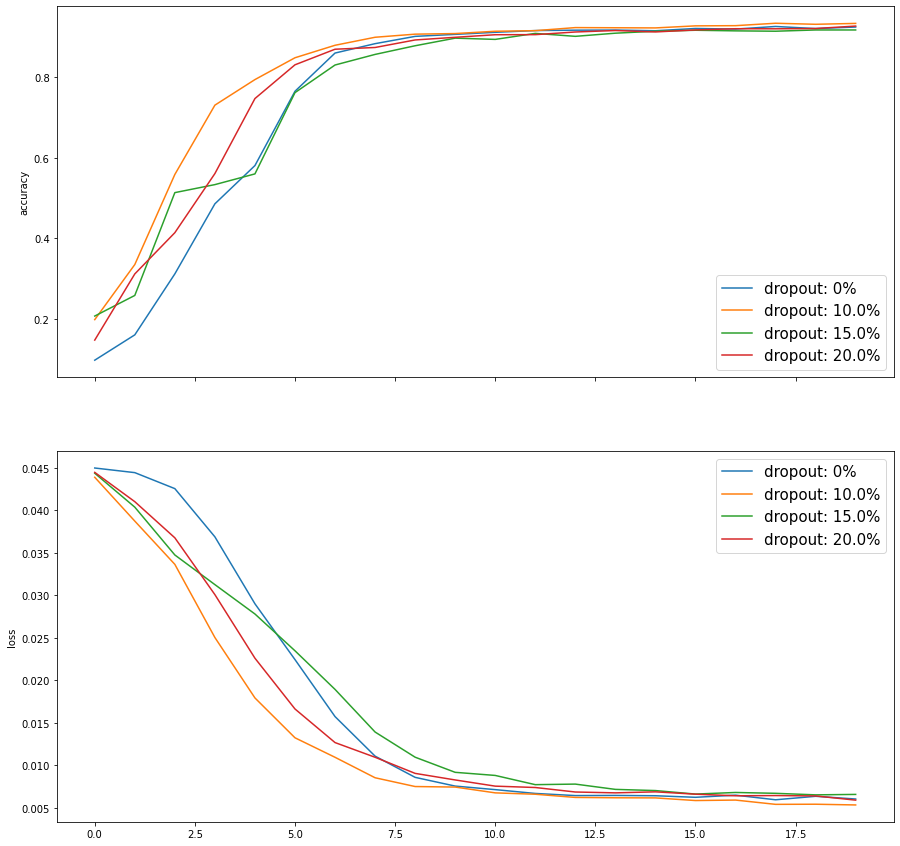

In [157]:
fig, axs = plt.subplots(nrows=2, figsize=(15, 15), sharex=True)
START_IDX = 0
names = [exp.name for exp in dropout_reg_exprs[START_IDX:]]
for exp in dropout_reg_exprs[START_IDX:]:
    axs[0].plot(exp.acc)
    axs[0].set(ylabel='accuracy')
    axs[1].plot(exp.loss)
    axs[1].set(ylabel='loss')
    
axs[0].legend(names, prop={'size': 15})
axs[1].legend(names, prop={'size': 15})

for ax in axs.flat:
    ax.label_outer()

In [158]:
best = ('', 0)
for e in dropout_reg_exprs:
    m = max(e.acc)
    n = e.name
    if m > best[1]:
        best = (n, m)
    print(f'acc for\t {n}: \t\t {m}')
print('-'*50)
print(f'overall best: {best}')

acc for	 dropout: 0%: 		 0.9261
acc for	 dropout: 10.0%: 		 0.9341
acc for	 dropout: 15.0%: 		 0.9174
acc for	 dropout: 20.0%: 		 0.9271
--------------------------------------------------
overall best: ('dropout: 10.0%', 0.9341)
